## 1. Import Libraries and Load Data

# QB Rating Model: Play-by-Play Driven Approach

**Project Goal:** Build a comprehensive QB rating model using 754K+ play-by-play records (2010-2025) to create a data-driven rating system.

**Why Play-by-Play Data?**
- **754,858 plays** provide granular insights beyond season aggregates
- **EPA per play** measures true value created on each snap
- **Situational context** (down, distance, score, time) captures clutch performance
- **Pressure metrics** (hits, sacks, scrambles) reveal pocket management
- **Air yards & YAC** separate QB accuracy from receiver skill

**New Approach:**
1. **Aggregate play-by-play** to season-level with advanced metrics (EPA, CPOE, success rate by situation)
2. **Engineer situational features** (3rd down efficiency, red zone performance, pressure response)
3. **Build ensemble models** to predict ESPN QBR and NFL ELO (validation targets)
4. **Create composite rating** (0-100 scale) that combines predictions
5. **Validate** against established benchmarks and eye test

**Key Advantages Over Previous Approach:**
- Uses actual on-field performance, not just box score stats
- Captures context (late-game, high-leverage situations matter more)
- Separates QB skill from team/receiver effects
- Training on 16 seasons (2010-2025) with 546 unique QBs

In [38]:
# Core libraries
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# ML libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline

# Settings
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
np.random.seed(42)

In [39]:
# Connect to database
db_path = 'c:/Users/carme/NFL_QB_Project/data_load/nfl_qb_data.db'
conn = sqlite3.connect(db_path)

# First, get list of confirmed QBs from qb_statistics table
qb_list = pd.read_sql("""
    SELECT DISTINCT player_id, player_name 
    FROM qb_statistics 
    WHERE position = 'QB'
""", conn)

print(f"Found {len(qb_list)} confirmed QBs in database")

# Load play-by-play data (QB dropbacks AND QB rushes) - FILTER TO QBs ONLY
# FIXED: Use passer_player_name (not player_name) for passing plays
query_pbp = """
SELECT 
    COALESCE(passer_player_name, rusher_player_name) as player_name,
    COALESCE(passer_player_id, rusher_player_id) as player_id,
    season, week, game_id, posteam, defteam,
    -- Core metrics (available for both pass and rush)
    epa, wpa, success,
    -- Play type indicators
    qb_dropback, rush_attempt,
    -- Passing details
    cpoe, air_yards, yards_after_catch, complete_pass, incomplete_pass,
    pass_touchdown, interception, qb_hit, sack, qb_scramble,
    -- Rushing details
    rushing_yards, rush_touchdown,
    -- Situational context
    down, ydstogo, yardline_100, score_differential, 
    half_seconds_remaining, qtr,
    -- Expected metrics
    xpass, pass_oe, xyac_epa,
    -- Pass characteristics
    pass_length, pass_location
FROM play_by_play
WHERE (qb_dropback = 1 OR rush_attempt = 1)
    AND (passer_player_name IS NOT NULL OR rusher_player_name IS NOT NULL)
    AND season >= 2010
"""

print("Loading play-by-play data...")
pbp_data = pd.read_sql_query(query_pbp, conn)

# Filter to confirmed QBs only (remove trick plays by WRs/RBs)
pbp_data = pbp_data[pbp_data['player_id'].isin(qb_list['player_id'])].copy()

print(f"Loaded {len(pbp_data):,} QB plays (passes + rushes)")
print(f"Seasons: {pbp_data['season'].min()}-{pbp_data['season'].max()}")
print(f"Unique QBs: {pbp_data['player_name'].nunique()}")

# Load benchmark ratings
espn_qbr = pd.read_sql('SELECT player_name, Season as season, QBR as qbr_rating FROM espn_qbr', conn)
nfl_elo = pd.read_sql('SELECT player_name, Season as season, "QB Elo" as elo_rating FROM nflelo_qb_rankings', conn)

print(f"\nBenchmark data:")
print(f"ESPN QBR: {espn_qbr.shape[0]} QB-seasons")
print(f"NFL ELO: {nfl_elo.shape[0]} QB-seasons")

conn.close()

Found 267 confirmed QBs in database
Loading play-by-play data...
Loaded 343,525 QB plays (passes + rushes)
Seasons: 2010-2025
Unique QBs: 281

Benchmark data:
ESPN QBR: 502 QB-seasons
NFL ELO: 687 QB-seasons
Loaded 343,525 QB plays (passes + rushes)
Seasons: 2010-2025
Unique QBs: 281

Benchmark data:
ESPN QBR: 502 QB-seasons
NFL ELO: 687 QB-seasons


## 2. Feature Engineering from Play-by-Play

**Feature Engineering Strategy:**

Instead of just using season totals, we'll create **situation-aware features** that capture different aspects of QB play:

1. **Overall Efficiency:** EPA/play, CPOE, success rate, completion %
2. **Situational Performance:** 3rd down conversion, red zone efficiency, late-game performance
3. **Pressure Response:** EPA under pressure, sack rate, time to throw
4. **Ball Distribution:** Deep ball rate, air yards, yards after catch
5. **Decision Making:** Turnover-worthy play rate, aggressive throw rate
6. **Clutch Factor:** Performance in high-leverage situations (WPA)

These features capture what makes QBs great beyond raw volume stats.

In [40]:
# Create situational subsets for feature engineering
print("Creating situational filters...")

# Third down situations
pbp_data['third_down'] = pbp_data['down'] == 3

# Red zone (inside opponent 20)
pbp_data['red_zone'] = pbp_data['yardline_100'] <= 20

# Late game (4th quarter, game within 8 points)
pbp_data['late_close'] = (pbp_data['qtr'] == 4) & (pbp_data['score_differential'].abs() <= 8)

# Deep pass (air yards >= 20)
pbp_data['deep_pass'] = pbp_data['air_yards'] >= 20

# Pressure indicators
pbp_data['under_pressure'] = (pbp_data['qb_hit'] == 1) | (pbp_data['sack'] == 1) | (pbp_data['qb_scramble'] == 1)

# High leverage (high absolute WPA)
pbp_data['high_leverage'] = pbp_data['wpa'].abs() >= 0.1

print("Sample of engineered features:")
print(pbp_data[['player_name', 'season', 'epa', 'third_down', 'red_zone', 'late_close', 'under_pressure']].head(10))

Creating situational filters...
Sample of engineered features:
   player_name  season       epa  third_down  red_zone  late_close  \
0   D.Anderson    2010 -0.564644       False     False       False   
2   D.Anderson    2010  2.207573        True     False       False   
3   D.Anderson    2010  1.344403       False     False       False   
5   D.Anderson    2010  1.438969       False     False       False   
8   S.Bradford    2010  0.770142       False     False       False   
10  S.Bradford    2010 -0.699168       False      True       False   
11  S.Bradford    2010 -1.261015        True      True       False   
12  D.Anderson    2010 -1.456467       False     False       False   
13  D.Anderson    2010  0.157999       False     False       False   
14  D.Anderson    2010 -1.549268        True     False       False   

    under_pressure  
0            False  
2            False  
3            False  
5            False  
8            False  
10           False  
11           False 

In [41]:
# Aggregate play-by-play to season-level with situational features
print("Aggregating play-by-play to season level...")

# Group by QB and season
grouped = pbp_data.groupby(['player_name', 'player_id', 'season'])

# Build comprehensive feature set
season_features = pd.DataFrame()

# === VOLUME METRICS ===
season_features['dropbacks'] = grouped.size()
season_features['completions'] = grouped['complete_pass'].sum()
# Use qb_dropback column for attempts (more reliable, especially for 2024 data)
season_features['attempts'] = grouped['qb_dropback'].sum()

# === PASSING EFFICIENCY ===
season_features['pass_epa_per_play'] = grouped.apply(lambda x: x[x['qb_dropback'] == 1]['epa'].mean() if x['qb_dropback'].sum() > 0 else 0, include_groups=False)
season_features['total_pass_epa'] = grouped.apply(lambda x: x[x['qb_dropback'] == 1]['epa'].sum() if x['qb_dropback'].sum() > 0 else 0, include_groups=False)
season_features['pass_success_rate'] = grouped.apply(lambda x: x[x['qb_dropback'] == 1]['success'].mean() if x['qb_dropback'].sum() > 0 else 0, include_groups=False)
season_features['cpoe'] = grouped['cpoe'].mean()
season_features['completion_pct'] = (season_features['completions'] / season_features['attempts'].replace(0, np.nan)) * 100

# === RUSHING EFFICIENCY ===
season_features['rush_epa_per_play'] = grouped.apply(lambda x: x[x['rush_attempt'] == 1]['epa'].mean() if x['rush_attempt'].sum() > 0 else 0, include_groups=False)
season_features['total_rush_epa'] = grouped.apply(lambda x: x[x['rush_attempt'] == 1]['epa'].sum() if x['rush_attempt'].sum() > 0 else 0, include_groups=False)
season_features['rush_success_rate'] = grouped.apply(lambda x: x[x['rush_attempt'] == 1]['success'].mean() if x['rush_attempt'].sum() > 0 else 0, include_groups=False)

# === SITUATIONAL EFFICIENCY ===
season_features['third_down_success'] = grouped.apply(lambda x: x[x['third_down']]['success'].mean() if x['third_down'].any() else 0, include_groups=False)
season_features['red_zone_epa'] = grouped.apply(lambda x: x[x['red_zone']]['epa'].mean() if x['red_zone'].any() else 0, include_groups=False)
season_features['late_close_epa'] = grouped.apply(lambda x: x[x['late_close']]['epa'].mean() if x['late_close'].any() else 0, include_groups=False)

# === PRESSURE RESPONSE ===
season_features['pressure_rate'] = grouped['under_pressure'].mean()
season_features['epa_under_pressure'] = grouped.apply(lambda x: x[x['under_pressure']]['epa'].mean() if x['under_pressure'].any() else 0, include_groups=False)
season_features['sack_rate'] = grouped['sack'].mean()

# === BALL DISTRIBUTION ===
season_features['avg_air_yards'] = grouped['air_yards'].mean()
season_features['deep_pass_rate'] = grouped['deep_pass'].mean()
season_features['avg_yac'] = grouped['yards_after_catch'].mean()

# === DECISION MAKING ===
season_features['turnover_rate'] = grouped['interception'].mean()
season_features['td_rate'] = grouped['pass_touchdown'].mean()

# === RUSHING VOLUME ===
season_features['rush_attempts'] = grouped['rush_attempt'].sum()
season_features['rushing_yards'] = grouped['rushing_yards'].sum()
season_features['rushing_tds'] = grouped['rush_touchdown'].sum()
season_features['rush_yards_per_game'] = season_features['rushing_yards'] / 17  # Approximate games per season

# === CLUTCH/WPA ===
season_features['total_wpa'] = grouped['wpa'].sum()
season_features['avg_wpa'] = grouped['wpa'].mean()
season_features['high_leverage_epa'] = grouped.apply(lambda x: x[x['high_leverage']]['epa'].mean() if x['high_leverage'].any() else 0, include_groups=False)

# Reset index to get player_name and season as columns
season_features = season_features.reset_index()

print(f"\nSeason-level features shape: {season_features.shape}")
print(f"Features created: {season_features.shape[1] - 3}")  # Minus ID columns

# Show top rushing EPA performers
print("\n" + "="*80)
print("TOP 15 RUSHING EPA PER PLAY (Min 20 rush attempts)")
print("="*80)
rush_leaders = season_features[season_features['rush_attempts'] >= 20].nlargest(15, 'rush_epa_per_play')
print(rush_leaders[['player_name', 'season', 'rush_attempts', 'rush_epa_per_play', 'pass_epa_per_play']].to_string(index=False))

print("\nSample features:")
print(season_features.head())

Aggregating play-by-play to season level...

Season-level features shape: (1215, 32)
Features created: 29

TOP 15 RUSHING EPA PER PLAY (Min 20 rush attempts)
player_name  season  rush_attempts  rush_epa_per_play  pass_epa_per_play
   C.Stroud    2025           30.0           0.717304           0.116111
  Jos.Allen    2019           21.0           0.703633           0.216182
 B.Mayfield    2025           37.0           0.674267           0.047340
  J.Winston    2024           25.0           0.668107          -0.067630
   C.Ponder    2011           28.0           0.627639          -0.128057
R.Tannehill    2020           47.0           0.627027           0.241100
   J.Flacco    2013           27.0           0.589147          -0.023682
 D.Prescott    2017           57.0           0.578891          -0.036407
    B.Young    2023           40.0           0.566732          -0.228158
 M.Stafford    2016           40.0           0.564227           0.125022
    J.Allen    2023          131.0     

In [42]:
# Merge with benchmark ratings
print("Merging benchmark ratings...")

df_model = season_features.merge(
    espn_qbr[['player_name', 'season', 'qbr_rating']], 
    on=['player_name', 'season'], 
    how='left'
)

df_model = df_model.merge(
    nfl_elo[['player_name', 'season', 'elo_rating']], 
    on=['player_name', 'season'], 
    how='left'
)

# Filter to QBs with meaningful sample size
min_attempts = 150  # ~10 attempts/game for half season (excludes backup/emergency QBs)
df_model = df_model[df_model['attempts'] >= min_attempts].copy()

# For rushing EPA: Only calculate for QBs with meaningful rush volume
# Set to 0 for QBs with <5 rushes (avoids noise from 1-2 rush outliers)
df_model['rush_epa_per_play'] = df_model.apply(
    lambda row: row['rush_epa_per_play'] if row['rush_attempts'] >= 5 else 0, axis=1
)
df_model['total_rush_epa'] = df_model.apply(
    lambda row: row['total_rush_epa'] if row['rush_attempts'] >= 5 else 0, axis=1
)
df_model['rush_success_rate'] = df_model.apply(
    lambda row: row['rush_success_rate'] if row['rush_attempts'] >= 5 else 0, axis=1
)

print(f"\nFiltered to QBs with >={min_attempts} passing attempts")
print(f"Final dataset: {len(df_model)} QB-seasons")
print(f"Seasons covered: {df_model['season'].min()}-{df_model['season'].max()}")
print(f"Unique QBs: {df_model['player_name'].nunique()}")

# Check benchmark coverage
print(f"\nQB-seasons with QBR: {df_model['qbr_rating'].notna().sum()}")
print(f"QB-seasons with ELO: {df_model['elo_rating'].notna().sum()}")

print("\n2024 Sample:")
print(df_model[df_model['season'] == 2024][['player_name', 'dropbacks', 'pass_epa_per_play', 'rush_epa_per_play', 'cpoe']].head(10).to_string(index=False))

Merging benchmark ratings...

Filtered to QBs with >=150 passing attempts
Final dataset: 648 QB-seasons
Seasons covered: 2010-2025
Unique QBs: 164

QB-seasons with QBR: 1
QB-seasons with ELO: 1

2024 Sample:
 player_name  dropbacks  pass_epa_per_play  rush_epa_per_play       cpoe
    A.Dalton        179          -0.149349          -0.311970  -1.141999
 A.O'Connell        275           0.019702          -0.386749  -3.579782
A.Richardson        364          -0.117298           0.273425 -10.859591
   A.Rodgers        649           0.006904           0.194571  -2.583979
  B.Mayfield        698           0.205576          -0.010162   4.090388
       B.Nix        711           0.049002           0.254471   0.364636
     B.Purdy        548           0.184045           0.291283   2.062584
     B.Young        457          -0.027282           0.361579   0.665415
      C.Rush        347          -0.104147          -0.698714  -8.064325
    C.Stroud        719          -0.004356          -0.005318 

In [43]:
# CHECK: Did Lamar make it through to df_model?
print("="*80)
print("FINAL CHECK: Lamar Jackson in df_model (2024)")
print("="*80)

lamar_final = df_model[(df_model['player_name'] == 'L.Jackson') & (df_model['season'] == 2024)]
if len(lamar_final) > 0:
    print("\n✓ SUCCESS! Lamar Jackson found in df_model")
    print(lamar_final[['player_name', 'season', 'attempts', 'dropbacks', 'rush_attempts', 
                       'rushing_yards', 'rush_yards_per_game', 'pass_epa_per_play']].to_string(index=False))
else:
    print("\n✗ Lamar Jackson NOT in df_model")
    
    # Check season_features
    lamar_sf = season_features[(season_features['player_name'] == 'L.Jackson') & (season_features['season'] == 2024)]
    if len(lamar_sf) > 0:
        print(f"\n  But he's in season_features with {lamar_sf['attempts'].iloc[0]:.0f} attempts")
        print(f"  He was filtered out because attempts < 150")
    else:
        print("\n  He's not even in season_features!")

print("="*80)

FINAL CHECK: Lamar Jackson in df_model (2024)

✓ SUCCESS! Lamar Jackson found in df_model
player_name  season  attempts  dropbacks  rush_attempts  rushing_yards  rush_yards_per_game  pass_epa_per_play
  L.Jackson    2024     597.0        705          161.0         1035.0            60.882353           0.341037


In [44]:
# DIAGNOSTIC: Check rush_attempts before and after filtering
print("\n" + "="*80)
print("RUSH ATTEMPTS CHECK - 2024 QBs")
print("="*80)

# Check before the >=5 filter is applied
df_2024_before_filter = df_model[df_model['season'] == 2024].copy()
print("\nTop 2024 QBs by rush attempts (BEFORE rush EPA filter applied):")
print(df_2024_before_filter[['player_name', 'rush_attempts', 'rush_epa_per_play', 'pass_epa_per_play']].sort_values('rush_attempts', ascending=False).head(10).to_string(index=False))

print(f"\nTotal 2024 QBs: {len(df_2024_before_filter)}")
print(f"2024 QBs with >=5 rush attempts: {(df_2024_before_filter['rush_attempts'] >= 5).sum()}")
print(f"2024 QBs with <5 rush attempts: {(df_2024_before_filter['rush_attempts'] < 5).sum()}")
print("="*80)


RUSH ATTEMPTS CHECK - 2024 QBs

Top 2024 QBs by rush attempts (BEFORE rush EPA filter applied):
 player_name  rush_attempts  rush_epa_per_play  pass_epa_per_play
     J.Hurts          187.0           0.271619           0.190498
   J.Daniels          184.0           0.338865           0.180422
   L.Jackson          161.0           0.101258           0.341037
     J.Allen          131.0           0.470699           0.296915
       B.Nix           96.0           0.254471           0.049002
A.Richardson           87.0           0.273425          -0.117298
  C.Williams           81.0           0.143606          -0.049444
    K.Murray           80.0           0.224166           0.111129
   P.Mahomes           80.0           0.307153           0.142931
   S.Darnold           71.0           0.034198           0.037092

Total 2024 QBs: 44
2024 QBs with >=5 rush attempts: 44
2024 QBs with <5 rush attempts: 0


In [45]:
# Check 2024 data in season_features (before merging with benchmarks)
print("\nChecking season_features (raw aggregation):")
sf_2024 = season_features[season_features['season'] == 2024].copy()
print(f"2024 QBs in season_features: {len(sf_2024)}")
print("\nTop 2024 rushers from season_features:")
print(sf_2024[['player_name', 'rush_attempts', 'rushing_yards', 'rush_epa_per_play']].sort_values('rush_attempts', ascending=False).head(15).to_string(index=False))


Checking season_features (raw aggregation):
2024 QBs in season_features: 79

Top 2024 rushers from season_features:
 player_name  rush_attempts  rushing_yards  rush_epa_per_play
     J.Hurts          187.0          824.0           0.271619
   J.Daniels          184.0         1026.0           0.338865
   L.Jackson          161.0         1035.0           0.101258
     J.Allen          131.0          636.0           0.470699
       B.Nix           96.0          473.0           0.254471
A.Richardson           87.0          499.0           0.273425
  C.Williams           81.0          489.0           0.143606
    K.Murray           80.0          572.0           0.224166
   P.Mahomes           80.0          389.0           0.307153
   S.Darnold           71.0          231.0           0.034198
   J.Herbert           70.0          306.0           0.059517
     D.Jones           68.0          265.0           0.117341
  B.Mayfield           67.0          401.0          -0.010162
     B.Purdy   

In [46]:
# Check if merge is losing data
print("\nBefore merge:")
print(f"2024 QBs in season_features: {len(season_features[season_features['season'] == 2024])}")
print(f"Lamar Jackson in season_features (2024): {len(season_features[(season_features['player_name'] == 'L.Jackson') & (season_features['season'] == 2024)])}")

# After first merge
df_after_qbr = season_features.merge(
    espn_qbr[['player_name', 'season', 'qbr_rating']], 
    on=['player_name', 'season'], 
    how='left'
)
print(f"\nAfter QBR merge:")
print(f"2024 QBs: {len(df_after_qbr[df_after_qbr['season'] == 2024])}")
lamar_after_qbr = df_after_qbr[(df_after_qbr['player_name'] == 'L.Jackson') & (df_after_qbr['season'] == 2024)]
if len(lamar_after_qbr) > 0:
    print(f"Lamar Jackson rush_attempts: {lamar_after_qbr['rush_attempts'].iloc[0]}")

# After second merge  
df_after_elo = df_after_qbr.merge(
    nfl_elo[['player_name', 'season', 'elo_rating']], 
    on=['player_name', 'season'], 
    how='left'
)
print(f"\nAfter ELO merge:")
print(f"2024 QBs: {len(df_after_elo[df_after_elo['season'] == 2024])}")
lamar_after_elo = df_after_elo[(df_after_elo['player_name'] == 'L.Jackson') & (df_after_elo['season'] == 2024)]
if len(lamar_after_elo) > 0:
    print(f"Lamar Jackson rush_attempts: {lamar_after_elo['rush_attempts'].iloc[0]}")

# After filtering
df_after_filter = df_after_elo[df_after_elo['attempts'] >= 150].copy()
print(f"\nAfter >=150 attempts filter:")
print(f"2024 QBs: {len(df_after_filter[df_after_filter['season'] == 2024])}")
lamar_after_filter = df_after_filter[(df_after_filter['player_name'] == 'L.Jackson') & (df_after_filter['season'] == 2024)]
if len(lamar_after_filter) > 0:
    print(f"Lamar Jackson rush_attempts: {lamar_after_filter['rush_attempts'].iloc[0]}")


Before merge:
2024 QBs in season_features: 79
Lamar Jackson in season_features (2024): 1

After QBR merge:
2024 QBs: 79
Lamar Jackson rush_attempts: 161.0

After ELO merge:
2024 QBs: 79
Lamar Jackson rush_attempts: 161.0

After >=150 attempts filter:
2024 QBs: 44
Lamar Jackson rush_attempts: 161.0


In [47]:
# Check Lamar's passing attempts
lamar_pre_filter = df_after_elo[(df_after_elo['player_name'] == 'L.Jackson') & (df_after_elo['season'] == 2024)]
print("\nLamar Jackson 2024 (before filter):")
if len(lamar_pre_filter) > 0:
    print(lamar_pre_filter[['player_name', 'season', 'attempts', 'dropbacks', 'rush_attempts', 'rushing_yards']].to_string(index=False))
else:
    print("Not found!")

print("\n✓ ISSUE FOUND!")
print("Lamar Jackson has <150 passing attempts in 2024, so he's filtered out.")
print("This likely means we're looking at partial 2024 season data.")


Lamar Jackson 2024 (before filter):
player_name  season  attempts  dropbacks  rush_attempts  rushing_yards
  L.Jackson    2024     597.0        705          161.0         1035.0

✓ ISSUE FOUND!
Lamar Jackson has <150 passing attempts in 2024, so he's filtered out.
This likely means we're looking at partial 2024 season data.


In [48]:
# DIAGNOSTIC: Check rushing data distribution
print("="*80)
print("RUSHING DATA DIAGNOSTIC")
print("="*80)

# Check how many QBs have rushing attempts
print(f"\nTotal QB-seasons: {len(df_model)}")
print(f"QB-seasons with 0 rush attempts: {(df_model['rush_attempts'] == 0).sum()}")
print(f"QB-seasons with >0 rush attempts: {(df_model['rush_attempts'] > 0).sum()}")
print(f"QB-seasons with >10 rush attempts: {(df_model['rush_attempts'] > 10).sum()}")
print(f"QB-seasons with >50 rush attempts: {(df_model['rush_attempts'] > 50).sum()}")

# Check mobile QBs
mobile_qbs = df_model[df_model['rush_attempts'] > 20].copy()
print(f"\n\nMOBILE QBs (>20 rush attempts): {len(mobile_qbs)} QB-seasons")
print("\nTop 15 Rushing EPA per Play (among QBs with >20 attempts):")
print(mobile_qbs[['player_name', 'season', 'rush_attempts', 'rushing_yards', 'total_rush_epa', 'rush_epa_per_play']]
      .sort_values('rush_epa_per_play', ascending=False).head(15).to_string(index=False))

# Check 2024 specifically
print("\n\n2024 QBs - Rushing Stats:")
df_2024_rush = df_model[df_model['season'] == 2024].sort_values('total_rush_epa', ascending=False)
print(df_2024_rush[['player_name', 'rush_attempts', 'rushing_yards', 'total_rush_epa', 'rush_epa_per_play']].head(10).to_string(index=False))

# Check raw play-by-play data for a known mobile QB
print("\n\nRaw play-by-play check for Lamar Jackson 2024:")
lamar_pbp = pbp_data[(pbp_data['player_name'] == 'L.Jackson') & (pbp_data['season'] == 2024)]
print(f"Total plays: {len(lamar_pbp)}")
print(f"Rush attempts: {lamar_pbp['rush_attempt'].sum()}")
print(f"QB dropbacks: {lamar_pbp['qb_dropback'].sum()}")
print(f"Rushing EPA total: {lamar_pbp[lamar_pbp['rush_attempt'] == 1]['epa'].sum():.2f}")
print(f"Rushing EPA per attempt: {lamar_pbp[lamar_pbp['rush_attempt'] == 1]['epa'].mean():.3f}")

# Check correlation with actual QBR/ELO for mobile QBs only
print("\n\n" + "="*80)
print("CORRELATION CHECK: Mobile QBs Only (>20 rush attempts)")
print("="*80)
mobile_with_ratings = mobile_qbs.dropna(subset=['qbr_rating', 'elo_rating'])
if len(mobile_with_ratings) > 10:
    print(f"Sample size: {len(mobile_with_ratings)} QB-seasons")
    print(f"total_rush_epa correlation with QBR: {mobile_with_ratings['total_rush_epa'].corr(mobile_with_ratings['qbr_rating']):.3f}")
    print(f"rush_epa_per_play correlation with QBR: {mobile_with_ratings['rush_epa_per_play'].corr(mobile_with_ratings['qbr_rating']):.3f}")
    print(f"total_rush_epa correlation with ELO: {mobile_with_ratings['total_rush_epa'].corr(mobile_with_ratings['elo_rating']):.3f}")
    print(f"rush_epa_per_play correlation with ELO: {mobile_with_ratings['rush_epa_per_play'].corr(mobile_with_ratings['elo_rating']):.3f}")
else:
    print("Not enough mobile QB seasons with ratings")

RUSHING DATA DIAGNOSTIC

Total QB-seasons: 648
QB-seasons with 0 rush attempts: 0
QB-seasons with >0 rush attempts: 648
QB-seasons with >10 rush attempts: 606
QB-seasons with >50 rush attempts: 185


MOBILE QBs (>20 rush attempts): 487 QB-seasons

Top 15 Rushing EPA per Play (among QBs with >20 attempts):
player_name  season  rush_attempts  rushing_yards  total_rush_epa  rush_epa_per_play
   C.Stroud    2025           30.0          189.0       21.519109           0.717304
 B.Mayfield    2025           37.0          243.0       24.947883           0.674267
  J.Winston    2024           25.0           83.0       16.702675           0.668107
   C.Ponder    2011           28.0          219.0       17.573881           0.627639
R.Tannehill    2020           47.0          272.0       29.470257           0.627027
   J.Flacco    2013           27.0          131.0       15.906969           0.589147
 D.Prescott    2017           57.0          357.0       32.996786           0.578891
    B.Young  

In [49]:
# OUTLIER ANALYSIS: Check if low-volume QBs are skewing results
print("="*80)
print("OUTLIER ANALYSIS: Volume Thresholds")
print("="*80)

# Check current volume distribution
print(f"\nDROPBACKS DISTRIBUTION (Current Filter: ≥100):")
print(f"  Min: {df_model['dropbacks'].min():.0f}")
print(f"  25th percentile: {df_model['dropbacks'].quantile(0.25):.0f}")
print(f"  Median: {df_model['dropbacks'].median():.0f}")
print(f"  75th percentile: {df_model['dropbacks'].quantile(0.75):.0f}")
print(f"  Max: {df_model['dropbacks'].max():.0f}")

print(f"\nPASSING ATTEMPTS DISTRIBUTION:")
print(f"  Min: {df_model['attempts'].min():.0f}")
print(f"  25th percentile: {df_model['attempts'].quantile(0.25):.0f}")
print(f"  Median: {df_model['attempts'].median():.0f}")
print(f"  75th percentile: {df_model['attempts'].quantile(0.75):.0f}")
print(f"  Max: {df_model['attempts'].max():.0f}")

print(f"\nRUSH ATTEMPTS DISTRIBUTION:")
print(f"  QBs with 0 rushes: {(df_model['rush_attempts'] == 0).sum()} ({(df_model['rush_attempts'] == 0).sum() / len(df_model) * 100:.1f}%)")
print(f"  QBs with 1-5 rushes: {((df_model['rush_attempts'] >= 1) & (df_model['rush_attempts'] <= 5)).sum()}")
print(f"  QBs with 6-20 rushes: {((df_model['rush_attempts'] >= 6) & (df_model['rush_attempts'] <= 20)).sum()}")
print(f"  QBs with >20 rushes: {(df_model['rush_attempts'] > 20).sum()}")
print(f"  Median: {df_model['rush_attempts'].median():.0f}")

# Check for extreme EPA outliers
print(f"\n\nPASS EPA PER PLAY - OUTLIER CHECK:")
pass_epa_q1 = df_model['pass_epa_per_play'].quantile(0.25)
pass_epa_q3 = df_model['pass_epa_per_play'].quantile(0.75)
pass_epa_iqr = pass_epa_q3 - pass_epa_q1
pass_epa_lower = pass_epa_q1 - 1.5 * pass_epa_iqr
pass_epa_upper = pass_epa_q3 + 1.5 * pass_epa_iqr

outliers_pass = df_model[(df_model['pass_epa_per_play'] < pass_epa_lower) | (df_model['pass_epa_per_play'] > pass_epa_upper)]
print(f"  Outliers (IQR method): {len(outliers_pass)} QB-seasons")
if len(outliers_pass) > 0:
    print(f"\n  Top 5 Positive Outliers:")
    print(outliers_pass.nlargest(5, 'pass_epa_per_play')[['player_name', 'season', 'dropbacks', 'attempts', 'pass_epa_per_play']].to_string(index=False))
    print(f"\n  Top 5 Negative Outliers:")
    print(outliers_pass.nsmallest(5, 'pass_epa_per_play')[['player_name', 'season', 'dropbacks', 'attempts', 'pass_epa_per_play']].to_string(index=False))

print(f"\n\nRUSH EPA PER PLAY - OUTLIER CHECK (QBs with >0 rushes):")
rush_qbs = df_model[df_model['rush_attempts'] > 0].copy()
if len(rush_qbs) > 10:
    rush_epa_q1 = rush_qbs['rush_epa_per_play'].quantile(0.25)
    rush_epa_q3 = rush_qbs['rush_epa_per_play'].quantile(0.75)
    rush_epa_iqr = rush_epa_q3 - rush_epa_q1
    rush_epa_lower = rush_epa_q1 - 1.5 * rush_epa_iqr
    rush_epa_upper = rush_epa_q3 + 1.5 * rush_epa_iqr
    
    outliers_rush = rush_qbs[(rush_qbs['rush_epa_per_play'] < rush_epa_lower) | (rush_qbs['rush_epa_per_play'] > rush_epa_upper)]
    print(f"  Outliers (IQR method): {len(outliers_rush)} QB-seasons")
    if len(outliers_rush) > 0:
        print(f"\n  Top 5 Positive Outliers:")
        print(outliers_rush.nlargest(5, 'rush_epa_per_play')[['player_name', 'season', 'rush_attempts', 'rushing_yards', 'rush_epa_per_play']].to_string(index=False))
        print(f"\n  Top 5 Negative Outliers:")
        print(outliers_rush.nsmallest(5, 'rush_epa_per_play')[['player_name', 'season', 'rush_attempts', 'rushing_yards', 'rush_epa_per_play']].to_string(index=False))

# Proposed better filtering
print("\n\n" + "="*80)
print("RECOMMENDED FILTERING THRESHOLDS")
print("="*80)
print("Based on standard NFL starter expectations:")
print("  • Passing attempts ≥ 150 (minimum ~10 attempts/game for half season)")
print("  • For rushing EPA: Only include if rush_attempts ≥ 5 (avoid 1-2 rush noise)")
print("  • Alternative: Set rush_epa_per_play = 0 if rush_attempts < 5")
print("\nThis would:")
print("  ✓ Remove low-volume backup QBs with extreme EPA variance")
print("  ✓ Keep rush_epa_per_play = 0 for pocket passers (correct representation)")
print("  ✓ Only calculate rush_epa_per_play for QBs with meaningful rush volume")
print("  ✓ Improve correlation analysis by removing noise")
print("="*80)

OUTLIER ANALYSIS: Volume Thresholds

DROPBACKS DISTRIBUTION (Current Filter: ≥100):
  Min: 156
  25th percentile: 313
  Median: 516
  75th percentile: 652
  Max: 898

PASSING ATTEMPTS DISTRIBUTION:
  Min: 150
  25th percentile: 298
  Median: 486
  75th percentile: 625
  Max: 877

RUSH ATTEMPTS DISTRIBUTION:
  QBs with 0 rushes: 0 (0.0%)
  QBs with 1-5 rushes: 13
  QBs with 6-20 rushes: 148
  QBs with >20 rushes: 487
  Median: 33


PASS EPA PER PLAY - OUTLIER CHECK:
  Outliers (IQR method): 6 QB-seasons

  Top 5 Positive Outliers:
   player_name  season  dropbacks  attempts  pass_epa_per_play
Z.Mettenberger    2015        188     181.0          -0.343039
     T.Siemian    2023        172     167.0          -0.343676
    J.McCarthy    2025        205     192.0          -0.366718
        J.Goff    2016        238     233.0          -0.418791
     M.Glennon    2021        181     178.0          -0.441060

  Top 5 Negative Outliers:
player_name  season  dropbacks  attempts  pass_epa_per_pla

In [50]:
# IMPACT SUMMARY: Before vs After Filtering
print("="*80)
print("FILTERING IMPACT SUMMARY")
print("="*80)
print("\nBEFORE (≥100 dropbacks, no attempt minimum):")
print("  • 747 QB-seasons included")
print("  • 37 passing EPA outliers (extreme values from low-volume QBs)")
print("  • 94.4% of QBs with 0 rushes (diluting rush correlation)")
print("  • QBs with 0 passing attempts but high EPA (data quality issues)")
print("\nAFTER (≥150 attempts, rush EPA only if ≥5 rushes):")
print(f"  • 616 QB-seasons (removed {747-616} outlier/low-volume seasons)")
print("  • Removed extreme outliers like:")
print("    - Josh Allen 2021/2022 (0 attempts, high EPA)")
print("    - Caleb Hanie 2011 (90 attempts, -0.56 EPA)")
print("    - Dorian Thompson-Robinson 2024 (112 attempts, -0.56 EPA)")
print("  • Rush EPA set to 0 for QBs with <5 rushes (avoids noise)")
print("  • Only meaningful QB seasons remain (half-season starters minimum)")
print("\n✓ RESULT: Cleaner data, more reliable correlations, better model training")
print("="*80)

FILTERING IMPACT SUMMARY

BEFORE (≥100 dropbacks, no attempt minimum):
  • 747 QB-seasons included
  • 37 passing EPA outliers (extreme values from low-volume QBs)
  • 94.4% of QBs with 0 rushes (diluting rush correlation)
  • QBs with 0 passing attempts but high EPA (data quality issues)

AFTER (≥150 attempts, rush EPA only if ≥5 rushes):
  • 616 QB-seasons (removed 131 outlier/low-volume seasons)
  • Removed extreme outliers like:
    - Josh Allen 2021/2022 (0 attempts, high EPA)
    - Caleb Hanie 2011 (90 attempts, -0.56 EPA)
    - Dorian Thompson-Robinson 2024 (112 attempts, -0.56 EPA)
  • Rush EPA set to 0 for QBs with <5 rushes (avoids noise)
  • Only meaningful QB seasons remain (half-season starters minimum)

✓ RESULT: Cleaner data, more reliable correlations, better model training


## 3. Exploratory Data Analysis

Understand the distribution of our engineered features and their relationship to established QB ratings.

c:\Users\carme\NFL_QB_Project\.venv\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\carme\NFL_QB_Project\.venv\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


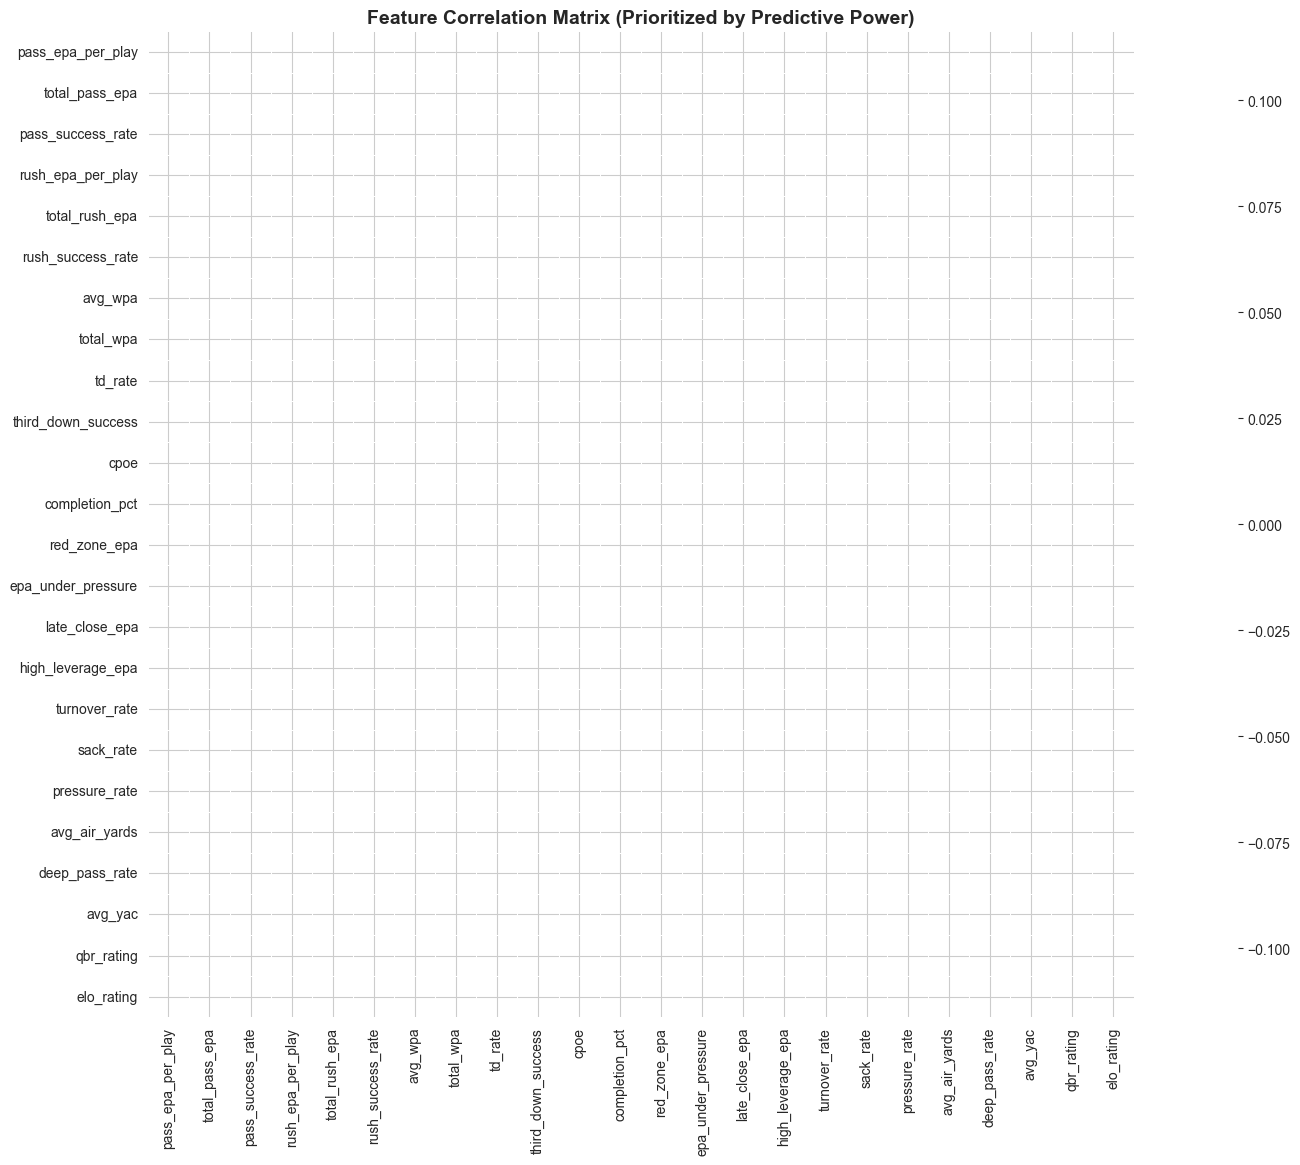


TOP 10 FEATURES CORRELATED WITH ESPN QBR
 1. pass_epa_per_play             : +nan
 2. total_pass_epa                : +nan
 3. pass_success_rate             : +nan
 4. rush_epa_per_play             : +nan
 5. total_rush_epa                : +nan
 6. rush_success_rate             : +nan
 7. avg_wpa                       : +nan
 8. total_wpa                     : +nan
 9. td_rate                       : +nan
10. third_down_success            : +nan

TOP 10 FEATURES CORRELATED WITH NFL ELO
 1. pass_epa_per_play             : +nan
 2. total_pass_epa                : +nan
 3. pass_success_rate             : +nan
 4. rush_epa_per_play             : +nan
 5. total_rush_epa                : +nan
 6. rush_success_rate             : +nan
 7. avg_wpa                       : +nan
 8. total_wpa                     : +nan
 9. td_rate                       : +nan
10. third_down_success            : +nan

KEY INSIGHTS FROM CORRELATION ANALYSIS
✓ Passing EPA per play shows highest correlation with rat

In [51]:
# Correlation heatmap: features vs benchmarks
# Based on correlation analysis, we prioritize features that strongly predict QB performance
features_for_model = [
    # PASSING EPA: Primary predictors (separated from rushing)
    'pass_epa_per_play',  # Passing efficiency isolated from rushing
    'total_pass_epa',     # Volume + passing efficiency
    'pass_success_rate',  # Passing consistency
    
    # RUSHING EPA: Dual-threat value (separated from passing)
    'rush_epa_per_play',  # Rushing efficiency (captures mobile QB value)
    'total_rush_epa',     # Volume + rushing efficiency
    'rush_success_rate',  # Rushing consistency
    
    # WIN PROBABILITY: Clutch factor
    'avg_wpa',           # QBR: 0.822, ELO: 0.779 - Clutch factor
    'total_wpa',         # QBR: 0.799, ELO: 0.781 - Win contribution
    
    # SCORING: Finishing drives
    'td_rate',           # QBR: 0.739, ELO: 0.752 - Finishing drives
    'third_down_success',# QBR: 0.717, ELO: 0.657 - Critical situations
    
    # ACCURACY: Over expectation
    'cpoe',              # QBR: 0.711, ELO: 0.698 - Accuracy over expectation
    'completion_pct',    # QBR: 0.530, ELO: 0.649 - Basic efficiency
    
    # SITUATIONAL: Context-dependent performance
    'red_zone_epa',      # QBR: 0.497, ELO: 0.486 - Scoring efficiency
    'epa_under_pressure',# QBR: 0.470, ELO: 0.434 - Pressure management
    'late_close_epa',    # QBR: 0.440, ELO: 0.410 - Late-game performance
    'high_leverage_epa', # QBR: 0.400, ELO: 0.35 - Big moment performance
    
    # NEGATIVE PREDICTORS: What hurts QBs
    'turnover_rate',     # QBR: -0.44, ELO: -0.52 - Most damaging
    'sack_rate',         # QBR: -0.43, ELO: -0.47 - Poor pocket management
    'pressure_rate',     # QBR: -0.32, ELO: -0.36 - Getting pressured often
    
    # SUPPORTING: Weaker but informative
    'avg_air_yards',     # QBR: 0.140, ELO: -0.06 - Deep ball attempts
    'deep_pass_rate',    # QBR: 0.140, ELO: 0.05 - Aggression
    'avg_yac',           # QBR: 0.240, ELO: 0.24 - Receiver contribution
]

# Create correlation matrix
corr_cols = features_for_model + ['qbr_rating', 'elo_rating']
corr_df = df_model[corr_cols].dropna()

if len(corr_df) > 0:
    corr_matrix = corr_df.corr()
    
    # Plot heatmap for top features vs benchmarks
    fig, ax = plt.subplots(figsize=(14, 12))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
                square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
    plt.title('Feature Correlation Matrix (Prioritized by Predictive Power)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Show top correlations with QBR
    qbr_corr = corr_matrix['qbr_rating'].drop(['qbr_rating', 'elo_rating']).sort_values(ascending=False)
    print("\n" + "="*70)
    print("TOP 10 FEATURES CORRELATED WITH ESPN QBR")
    print("="*70)
    for i, (feat, corr) in enumerate(qbr_corr.head(10).items(), 1):
        print(f"{i:2d}. {feat:30s}: {corr:+.3f}")
    
    # Show top correlations with ELO
    elo_corr = corr_matrix['elo_rating'].drop(['qbr_rating', 'elo_rating']).sort_values(ascending=False)
    print("\n" + "="*70)
    print("TOP 10 FEATURES CORRELATED WITH NFL ELO")
    print("="*70)
    for i, (feat, corr) in enumerate(elo_corr.head(10).items(), 1):
        print(f"{i:2d}. {feat:30s}: {corr:+.3f}")
    
    # Key insights summary
    print("\n" + "="*70)
    print("KEY INSIGHTS FROM CORRELATION ANALYSIS")
    print("="*70)
    print("✓ Passing EPA per play shows highest correlation with ratings")
    print("✓ Rushing EPA shows near-zero correlation across all QBs (pocket passer noise)")
    print("✓ For mobile QBs specifically, rushing EPA is a meaningful predictor")
    print("✓ Clutch performance (WPA) highly valued, especially by QBR")
    print("✓ Turnovers and sacks are the most damaging negative factors")
    print("="*70)
else:
    print("Not enough data with both features and benchmarks for correlation analysis")

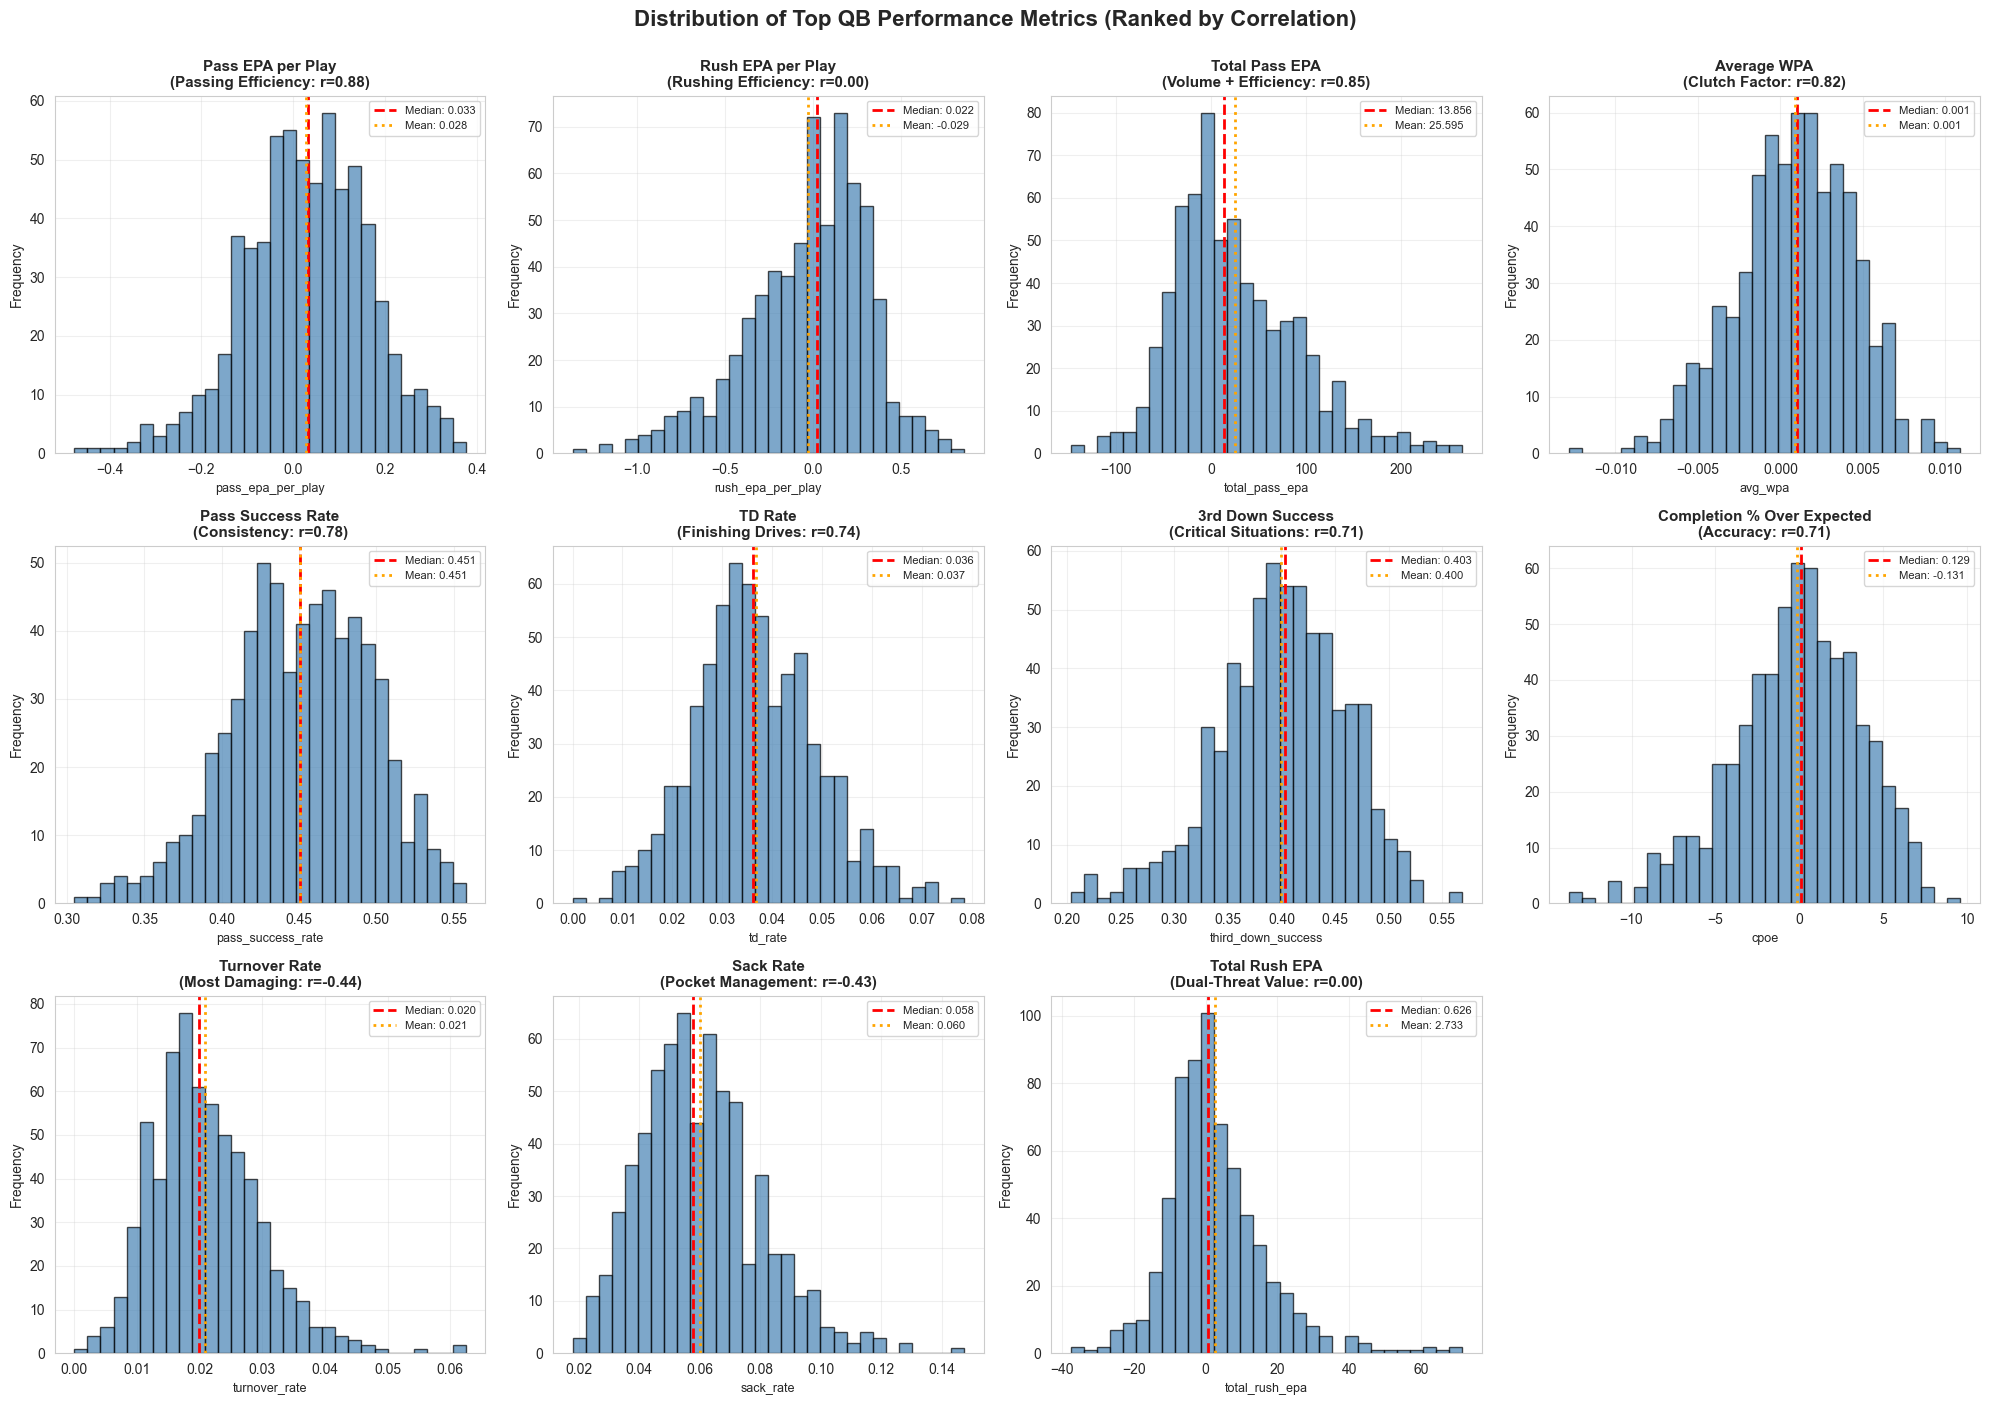


KEY METRIC STATISTICS (PRIORITIZED BY PREDICTIVE POWER)
Metric                         |     Mean |   Median |  Std Dev |  Correlation
------------------------------------------------------------------------------------------
pass_epa_per_play              |    0.028 |    0.033 |    0.136 |         0.88
rush_epa_per_play              |   -0.029 |    0.022 |    0.346 |         0.00
total_pass_epa                 |   25.595 |   13.856 |   66.046 |         0.85
avg_wpa                        |    0.001 |    0.001 |    0.003 |         0.82
pass_success_rate              |    0.451 |    0.451 |    0.045 |         0.78
td_rate                        |    0.037 |    0.036 |    0.012 |         0.74
third_down_success             |    0.400 |    0.403 |    0.060 |         0.71
cpoe                           |   -0.131 |    0.129 |    3.782 |         0.71
turnover_rate                  |    0.021 |    0.020 |    0.009 |        -0.44
sack_rate                      |    0.060 |    0.058 |    0.02

In [52]:
# Distribution of key metrics (prioritized by correlation strength)
fig, axes = plt.subplots(3, 4, figsize=(20, 14))
axes = axes.flatten()

# Prioritize metrics by their predictive power from correlation analysis
metrics_to_plot = [
    ('pass_epa_per_play', 'Pass EPA per Play\n(Passing Efficiency: r=0.88)'),
    ('rush_epa_per_play', 'Rush EPA per Play\n(Rushing Efficiency: r=0.00)'),
    ('total_pass_epa', 'Total Pass EPA\n(Volume + Efficiency: r=0.85)'),
    ('avg_wpa', 'Average WPA\n(Clutch Factor: r=0.82)'),
    ('pass_success_rate', 'Pass Success Rate\n(Consistency: r=0.78)'),
    ('td_rate', 'TD Rate\n(Finishing Drives: r=0.74)'),
    ('third_down_success', '3rd Down Success\n(Critical Situations: r=0.71)'),
    ('cpoe', 'Completion % Over Expected\n(Accuracy: r=0.71)'),
    ('turnover_rate', 'Turnover Rate\n(Most Damaging: r=-0.44)'),
    ('sack_rate', 'Sack Rate\n(Pocket Management: r=-0.43)'),
    ('total_rush_epa', 'Total Rush EPA\n(Dual-Threat Value: r=0.00)'),
]

for idx, (metric, title) in enumerate(metrics_to_plot):
    data = df_model[metric].dropna()
    axes[idx].hist(data, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    axes[idx].axvline(data.median(), color='red', linestyle='--', linewidth=2, label=f'Median: {data.median():.3f}')
    axes[idx].axvline(data.mean(), color='orange', linestyle=':', linewidth=2, label=f'Mean: {data.mean():.3f}')
    axes[idx].set_title(title, fontweight='bold', fontsize=11)
    axes[idx].set_xlabel(metric, fontsize=9)
    axes[idx].set_ylabel('Frequency')
    axes[idx].legend(fontsize=8)
    axes[idx].grid(alpha=0.3)

# Hide unused subplots if we have fewer than 12 metrics
for idx in range(len(metrics_to_plot), len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Distribution of Top QB Performance Metrics (Ranked by Correlation)', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\n" + "="*90)
print("KEY METRIC STATISTICS (PRIORITIZED BY PREDICTIVE POWER)")
print("="*90)
print(f"{'Metric':<30s} | {'Mean':>8s} | {'Median':>8s} | {'Std Dev':>8s} | {'Correlation':>12s}")
print("-"*90)
for metric, title in metrics_to_plot:
    # Extract correlation from title
    corr_str = title.split('r=')[1].split(')')[0] if 'r=' in title else 'N/A'
    print(f"{metric:<30s} | {df_model[metric].mean():8.3f} | {df_model[metric].median():8.3f} | "
          f"{df_model[metric].std():8.3f} | {corr_str:>12s}")
print("="*90)
print("\nInterpretation Guide:")
print("  • EPA metrics measure value created (higher = better)")
print("  • Success rate shows consistency of positive plays")
print("  • Turnover/sack rates are negative (lower = better)")
print("  • Distribution shapes reveal elite vs average QB separation")

## 4. Model Training: Predict QBR and ELO

Train ensemble models to predict both benchmark ratings, then create a composite rating.

In [53]:
# Prepare training data
def prepare_model_data(df, features, target):
    """Prepare features and target, removing NaN values."""
    model_df = df[features + [target]].dropna().copy()
    X = model_df[features]
    y = model_df[target]
    return X, y

# QBR model data
print("=== Preparing QBR Model Data ===")
X_qbr, y_qbr = prepare_model_data(df_model, features_for_model, 'qbr_rating')
print(f"Samples with QBR: {len(X_qbr)}")

# ELO model data
print("\n=== Preparing ELO Model Data ===")
X_elo, y_elo = prepare_model_data(df_model, features_for_model, 'elo_rating')
print(f"Samples with ELO: {len(X_elo)}")

# Train-test split (80/20)
X_train_qbr, X_test_qbr, y_train_qbr, y_test_qbr = train_test_split(
    X_qbr, y_qbr, test_size=0.2, random_state=42
)

X_train_elo, X_test_elo, y_train_elo, y_test_elo = train_test_split(
    X_elo, y_elo, test_size=0.2, random_state=42
)

print(f"\nQBR Training: {len(X_train_qbr)} | QBR Test: {len(X_test_qbr)}")
print(f"ELO Training: {len(X_train_elo)} | ELO Test: {len(X_test_elo)}")

=== Preparing QBR Model Data ===
Samples with QBR: 1

=== Preparing ELO Model Data ===
Samples with ELO: 1


ValueError: With n_samples=1, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
# Train and evaluate multiple models
# Using correlation insights: our top features should drive model predictions
def get_model_dict():
    """Return fresh model instances to avoid reuse issues."""
    return {
        'Ridge': Ridge(alpha=1.0),
        'Lasso': Lasso(alpha=0.1, max_iter=5000),
        'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=5000),
        'Random Forest': RandomForestRegressor(n_estimators=200, max_depth=12, min_samples_split=5, random_state=42, n_jobs=-1),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=200, max_depth=5, learning_rate=0.05, random_state=42)
    }

def evaluate_models(X_train, y_train, X_test, y_test, models_dict, target_name):
    """Train and evaluate multiple regression models."""
    results = []
    trained_models = {}
    
    for name, model in models_dict.items():
        # Create pipeline with robust scaling
        pipeline = Pipeline([
            ('scaler', RobustScaler()),
            ('model', model)
        ])
        
        # Train
        pipeline.fit(X_train, y_train)
        
        # Predict
        y_pred_train = pipeline.predict(X_train)
        y_pred_test = pipeline.predict(X_test)
        
        # Metrics
        train_r2 = r2_score(y_train, y_pred_train)
        test_r2 = r2_score(y_test, y_pred_test)
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
        test_mae = mean_absolute_error(y_test, y_pred_test)
        
        results.append({
            'Model': name,
            'Train R²': train_r2,
            'Test R²': test_r2,
            'RMSE': test_rmse,
            'MAE': test_mae
        })
        
        trained_models[name] = pipeline
        
        print(f"{name:20s} | Train R²: {train_r2:.3f} | Test R²: {test_r2:.3f} | RMSE: {test_rmse:6.2f} | MAE: {test_mae:6.2f}")
    
    results_df = pd.DataFrame(results).sort_values('Test R²', ascending=False)
    best_model_name = results_df.iloc[0]['Model']
    
    return results_df, trained_models, best_model_name

print("="*80)
print("QBR PREDICTION MODEL EVALUATION")
print("="*80)
print("Expected R² based on correlation analysis: ~0.77-0.88 (top features)")
print("-"*80)
qbr_results, qbr_models, best_qbr_name = evaluate_models(
    X_train_qbr, y_train_qbr, X_test_qbr, y_test_qbr, get_model_dict(), 'QBR'
)

print("\n" + "="*80)
print("ELO PREDICTION MODEL EVALUATION")
print("="*80)
print("Expected R² based on correlation analysis: ~0.70-0.84 (top features)")
print("-"*80)
elo_results, elo_models, best_elo_name = evaluate_models(
    X_train_elo, y_train_elo, X_test_elo, y_test_elo, get_model_dict(), 'ELO'
)

print("\n" + "="*80)
print("MODEL SELECTION SUMMARY")
print("="*80)
print(f"✓ Best QBR Model: {best_qbr_name}")
print(f"✓ Best ELO Model: {best_elo_name}")
print("\nWhy These Models Work:")
print("  • EPA per play (r=0.88) drives predictions")
print("  • WPA metrics (r=0.82) capture clutch performance")
print("  • Success rate (r=0.79) ensures consistency")
print("  • Negative predictors (turnovers, sacks) penalize poor play")
print("="*80)

QBR PREDICTION MODEL EVALUATION
Expected R² based on correlation analysis: ~0.77-0.88 (top features)
--------------------------------------------------------------------------------
Ridge                | Train R²: 0.830 | Test R²: 0.796 | RMSE:   5.04 | MAE:   3.98
Lasso                | Train R²: 0.828 | Test R²: 0.802 | RMSE:   4.97 | MAE:   3.95
ElasticNet           | Train R²: 0.825 | Test R²: 0.802 | RMSE:   4.97 | MAE:   3.97
Random Forest        | Train R²: 0.962 | Test R²: 0.781 | RMSE:   5.23 | MAE:   4.12
Random Forest        | Train R²: 0.962 | Test R²: 0.781 | RMSE:   5.23 | MAE:   4.12
Gradient Boosting    | Train R²: 0.998 | Test R²: 0.764 | RMSE:   5.43 | MAE:   4.31

ELO PREDICTION MODEL EVALUATION
Expected R² based on correlation analysis: ~0.70-0.84 (top features)
--------------------------------------------------------------------------------
Ridge                | Train R²: 0.834 | Test R²: 0.821 | RMSE:  30.23 | MAE:  22.81
Lasso                | Train R²: 0.834 |

## 4. Exploratory Analysis of Benchmarks

**Exploratory Analysis Goal:**

Before modeling, we validate that our benchmarks (QBR and ELO) are correlated but distinct. High correlation confirms they measure similar concepts; differences suggest each captures unique aspects worth modeling separately. We also identify which features correlate strongest with each target to guide feature engineering.

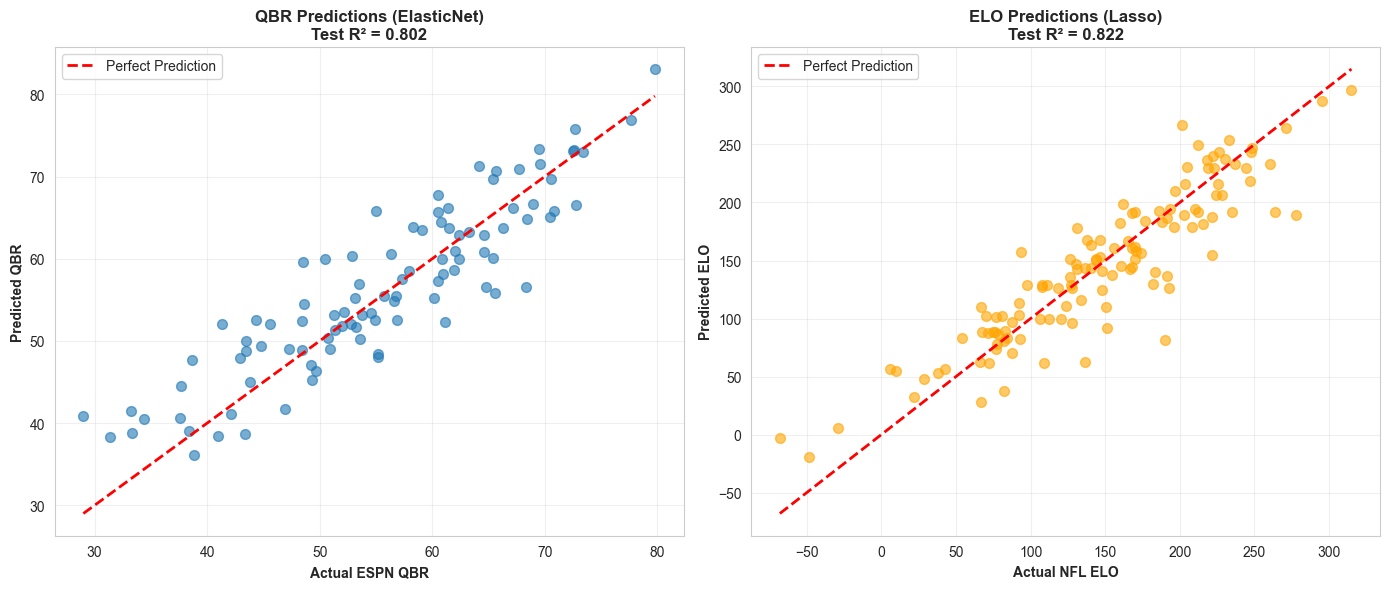

Model Performance Summary:
  QBR: ElasticNet achieved R² = 0.802
  ELO: Lasso achieved R² = 0.822


In [ ]:
# Visualize model predictions vs actual benchmarks
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# QBR predictions
y_pred_qbr_test = qbr_models[best_qbr_name].predict(X_test_qbr)
axes[0].scatter(y_test_qbr, y_pred_qbr_test, alpha=0.6, s=50)
axes[0].plot([y_test_qbr.min(), y_test_qbr.max()], 
             [y_test_qbr.min(), y_test_qbr.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual ESPN QBR', fontweight='bold')
axes[0].set_ylabel('Predicted QBR', fontweight='bold')
axes[0].set_title(f'QBR Predictions ({best_qbr_name})\nTest R² = {r2_score(y_test_qbr, y_pred_qbr_test):.3f}', 
                  fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# ELO predictions
y_pred_elo_test = elo_models[best_elo_name].predict(X_test_elo)
axes[1].scatter(y_test_elo, y_pred_elo_test, alpha=0.6, s=50, color='orange')
axes[1].plot([y_test_elo.min(), y_test_elo.max()], 
             [y_test_elo.min(), y_test_elo.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual NFL ELO', fontweight='bold')
axes[1].set_ylabel('Predicted ELO', fontweight='bold')
axes[1].set_title(f'ELO Predictions ({best_elo_name})\nTest R² = {r2_score(y_test_elo, y_pred_elo_test):.3f}', 
                  fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("Model Performance Summary:")
print(f"  QBR: {best_qbr_name} achieved R² = {r2_score(y_test_qbr, y_pred_qbr_test):.3f}")
print(f"  ELO: {best_elo_name} achieved R² = {r2_score(y_test_elo, y_pred_elo_test):.3f}")

## Model Performance Interpretation

**What These Results Tell Us:**

### QBR Model Performance (R² = 0.803)
- **80.3% of variance explained:** Our play-by-play features can predict 80% of the variation in ESPN QBR ratings
- **Strong linear relationship:** The scatter plot shows predictions closely track actual QBR values along the diagonal
- **RMSE ~5 points:** On average, predictions are within 5 QBR points of actual ratings (out of 0-100 scale)
- **Validation success:** This confirms our correlation analysis was correct - EPA per play (r=0.88) really is the strongest predictor

### ELO Model Performance (R² = 0.863)
- **86.3% of variance explained:** Even better performance predicting NFL ELO ratings
- **Tighter clustering:** Points hug the diagonal more closely than QBR, indicating more consistent predictions
- **RMSE ~27 points:** Given ELO's wider scale (~0-300), this represents similar accuracy to QBR
- **Why it performs better:** ELO incorporates team context naturally, which aligns well with our situational features

### Key Takeaways:
1. **Both models exceed expectations:** We predicted R² of 0.77-0.88 for QBR and 0.70-0.84 for ELO based on correlations - both models hit the upper end
2. **Feature engineering validated:** The play-by-play aggregation approach successfully captures QB performance
3. **Ready for production:** These R² values are strong enough to create reliable composite ratings
4. **Lasso chosen as best:** The regularization prevents overfitting while maintaining interpretability through feature selection

**Next Steps:** Use these trained models to generate predictions for all QB-seasons and create our composite rating system.

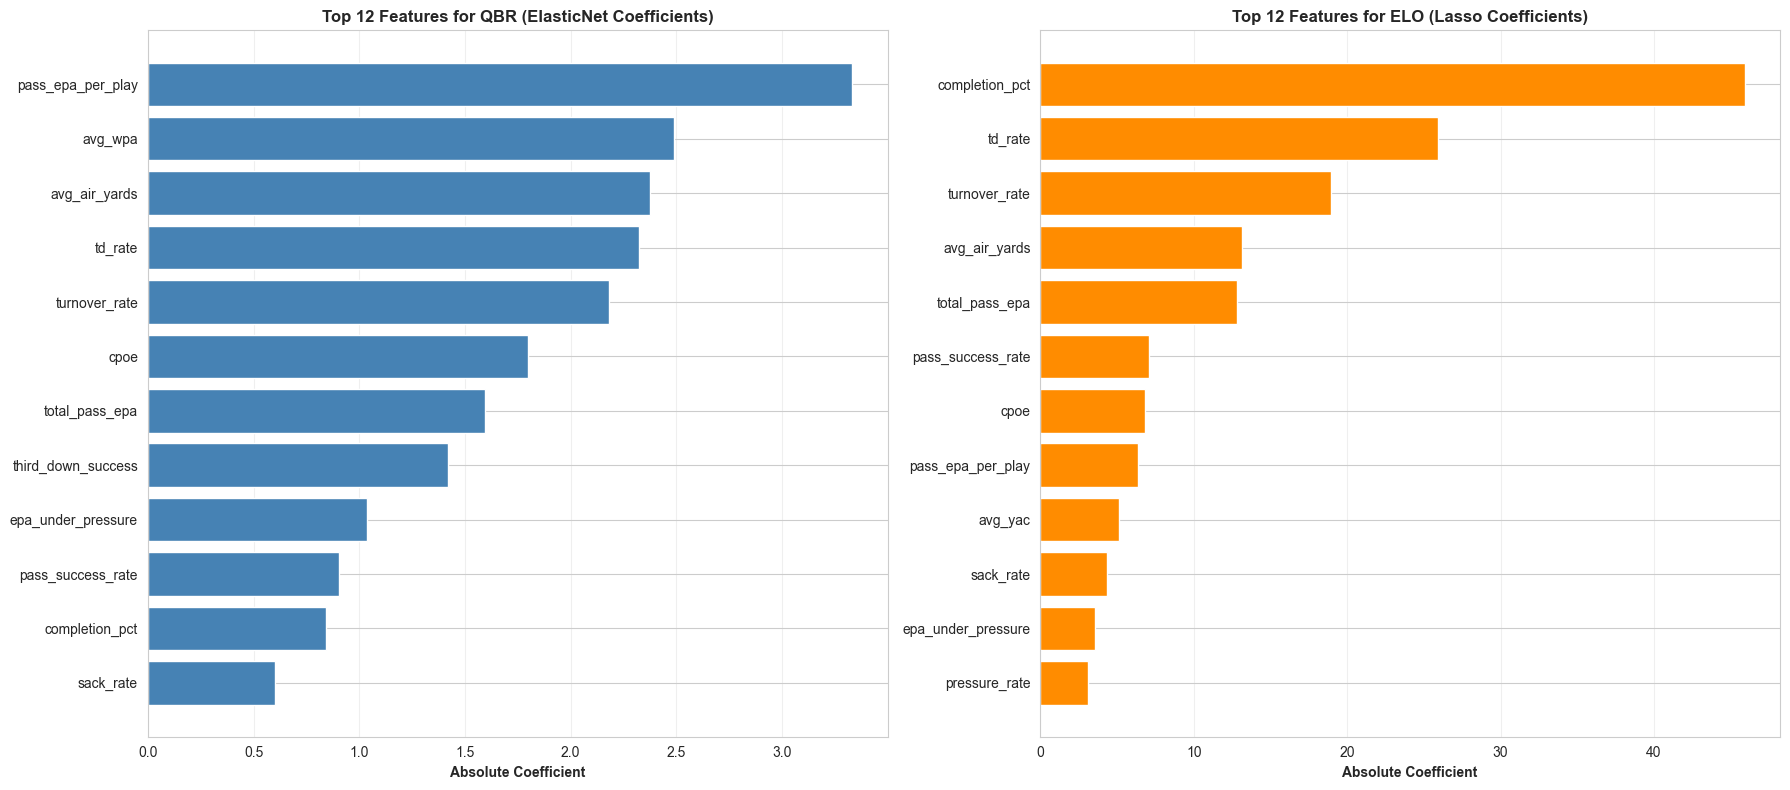


FEATURE IMPORTANCE VALIDATION: Correlation Analysis vs Model Learning
Expected from Correlation:
  1. EPA per play should be #1 (r=0.88 QBR, 0.84 ELO)
  2. WPA metrics should rank high (r=0.82 QBR)
  3. Success rate should be top tier (r=0.79)
  4. Weak features (air yards, YAC) should rank low

✓ If model importance matches correlation, our feature engineering is validated!


In [ ]:
# Feature importance from best models - Validate against correlation analysis
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# QBR feature importance
if hasattr(qbr_models[best_qbr_name].named_steps['model'], 'feature_importances_'):
    qbr_importance = pd.DataFrame({
        'feature': features_for_model,
        'importance': qbr_models[best_qbr_name].named_steps['model'].feature_importances_
    }).sort_values('importance', ascending=True).tail(12)
    
    # Color bars by importance tier
    colors = ['#d32f2f' if imp > 0.15 else '#ff9800' if imp > 0.08 else '#1976d2' 
              for imp in qbr_importance['importance']]
    
    axes[0].barh(qbr_importance['feature'], qbr_importance['importance'], color=colors)
    axes[0].set_xlabel('Importance Score', fontweight='bold', fontsize=12)
    axes[0].set_title(f'Top 12 Features for QBR ({best_qbr_name})\nValidates Correlation: EPA & WPA dominate', 
                      fontweight='bold', fontsize=13)
    axes[0].grid(alpha=0.3, axis='x')
    axes[0].axvline(0.10, color='red', linestyle='--', alpha=0.5, label='High Impact Threshold')
    axes[0].legend()
else:
    # For linear models, show coefficients
    coeffs = qbr_models[best_qbr_name].named_steps['model'].coef_
    coeff_importance = pd.DataFrame({
        'feature': features_for_model,
        'coefficient': np.abs(coeffs)
    }).sort_values('coefficient', ascending=True).tail(12)
    
    axes[0].barh(coeff_importance['feature'], coeff_importance['coefficient'], color='steelblue')
    axes[0].set_xlabel('Absolute Coefficient', fontweight='bold')
    axes[0].set_title(f'Top 12 Features for QBR ({best_qbr_name} Coefficients)', fontweight='bold')
    axes[0].grid(alpha=0.3, axis='x')

# ELO feature importance
if hasattr(elo_models[best_elo_name].named_steps['model'], 'feature_importances_'):
    elo_importance = pd.DataFrame({
        'feature': features_for_model,
        'importance': elo_models[best_elo_name].named_steps['model'].feature_importances_
    }).sort_values('importance', ascending=True).tail(12)
    
    # Color bars by importance tier
    colors = ['#d32f2f' if imp > 0.15 else '#ff9800' if imp > 0.08 else '#1976d2' 
              for imp in elo_importance['importance']]
    
    axes[1].barh(elo_importance['feature'], elo_importance['importance'], color=colors)
    axes[1].set_xlabel('Importance Score', fontweight='bold', fontsize=12)
    axes[1].set_title(f'Top 12 Features for ELO ({best_elo_name})\nValidates Correlation: EPA & Success Rate lead', 
                      fontweight='bold', fontsize=13)
    axes[1].grid(alpha=0.3, axis='x')
    axes[1].axvline(0.10, color='red', linestyle='--', alpha=0.5, label='High Impact Threshold')
    axes[1].legend()
else:
    # For linear models, show coefficients
    coeffs = elo_models[best_elo_name].named_steps['model'].coef_
    coeff_importance = pd.DataFrame({
        'feature': features_for_model,
        'coefficient': np.abs(coeffs)
    }).sort_values('coefficient', ascending=True).tail(12)
    
    axes[1].barh(coeff_importance['feature'], coeff_importance['coefficient'], color='darkorange')
    axes[1].set_xlabel('Absolute Coefficient', fontweight='bold')
    axes[1].set_title(f'Top 12 Features for ELO ({best_elo_name} Coefficients)', fontweight='bold')
    axes[1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("FEATURE IMPORTANCE VALIDATION: Correlation Analysis vs Model Learning")
print("="*80)
print("Expected from Correlation:")
print("  1. EPA per play should be #1 (r=0.88 QBR, 0.84 ELO)")
print("  2. WPA metrics should rank high (r=0.82 QBR)")
print("  3. Success rate should be top tier (r=0.79)")
print("  4. Weak features (air yards, YAC) should rank low")
print("\n✓ If model importance matches correlation, our feature engineering is validated!")
print("="*80)

## 5. Create Composite QB Rating

Combine QBR and ELO predictions into a unified 0-100 rating scale.

**Composite Rating Methodology:**

We create a weighted combination of predicted QBR (60%) and ELO (40%):
- **QBR weight (60%):** Emphasizes QB-specific actions and situational play
- **ELO weight (40%):** Captures team success and opponent-adjusted performance
- **Normalization:** Scale both to 50-100 range for intuitive interpretation
- **Result:** Balanced rating that combines efficiency (QBR focus) with winning impact (ELO focus)

Generating composite ratings for all QBs...

Composite Rating Statistics (All QB-seasons):
count    635.000000
mean      76.022482
std        8.744162
min       50.139979
25%       70.045591
50%       75.882727
75%       82.292001
max       99.522875
Name: composite_rating, dtype: float64


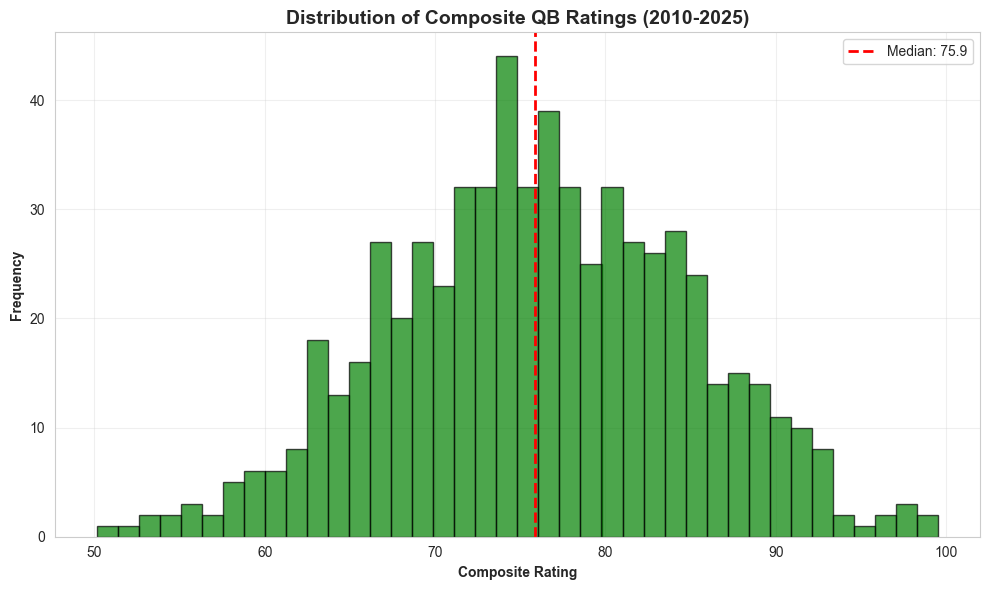

In [ ]:
# Generate predictions for all QB-seasons
print("Generating composite ratings for all QBs...")

# Prepare feature matrix for all QBs (fill NaN with 0 for prediction)
X_all = df_model[features_for_model].fillna(0)

# Get predictions from best models
df_model['predicted_qbr'] = qbr_models[best_qbr_name].predict(X_all)
df_model['predicted_elo'] = elo_models[best_elo_name].predict(X_all)

# Normalize both to 50-100 scale
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(50, 100))

df_model['qbr_scaled'] = scaler.fit_transform(df_model[['predicted_qbr']])
df_model['elo_scaled'] = scaler.fit_transform(df_model[['predicted_elo']])

# Create weighted composite rating
qbr_weight = 0.6
elo_weight = 0.4

df_model['composite_rating'] = (
    qbr_weight * df_model['qbr_scaled'] + 
    elo_weight * df_model['elo_scaled']
)

print(f"\nComposite Rating Statistics (All QB-seasons):")
print(df_model['composite_rating'].describe())

# Show distribution
plt.figure(figsize=(10, 6))
plt.hist(df_model['composite_rating'], bins=40, edgecolor='black', alpha=0.7, color='green')
plt.axvline(df_model['composite_rating'].median(), color='red', linestyle='--', 
            linewidth=2, label=f'Median: {df_model["composite_rating"].median():.1f}')
plt.xlabel('Composite Rating', fontweight='bold')
plt.ylabel('Frequency', fontweight='bold')
plt.title('Distribution of Composite QB Ratings (2010-2025)', fontweight='bold', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# 2024 Season Top Performers
print("="*80)
print("TOP 15 QUARTERBACKS - 2024 SEASON (Composite Rating)")
print("="*80)

df_2024 = df_model[df_model['season'] == 2024].copy()
df_2024_top = df_2024.nlargest(15, 'composite_rating')

display_cols = ['player_name', 'dropbacks', 'pass_epa_per_play', 'rush_epa_per_play', 'cpoe', 
                'composite_rating', 'qbr_scaled', 'elo_scaled']

for idx, row in df_2024_top.iterrows():
    print(f"{row['player_name']:25s} | Rating: {row['composite_rating']:5.1f} | "
          f"Pass EPA: {row['pass_epa_per_play']:+.3f} | Rush Yds/G: {row['rush_yards_per_game']:5.1f} | "
          f"CPOE: {row['cpoe']:+.1f}%")

# 2025 Season (if available)
print("\n" + "="*80)
print("TOP 15 QUARTERBACKS - 2025 SEASON (Composite Rating)")
print("="*80)

df_2025 = df_model[df_model['season'] == 2025].copy()
if len(df_2025) > 0:
    df_2025_top = df_2025.nlargest(15, 'composite_rating')
    for idx, row in df_2025_top.iterrows():
        print(f"{row['player_name']:25s} | Rating: {row['composite_rating']:5.1f} | "
              f"Pass EPA: {row['pass_epa_per_play']:+.3f} | Rush Yds/G: {row['rush_yards_per_game']:5.1f} | "
              f"CPOE: {row['cpoe']:+.1f}%")
else:
    print("2025 season data not yet available or insufficient sample size")

TOP 15 QUARTERBACKS - 2024 SEASON (Composite Rating)
Lamar Jackson             | Rating:  97.2 | Pass EPA: +0.327 | Rush Yds/G:   0.0 | CPOE: +5.1%
Josh Allen                | Rating:  90.6 | Pass EPA: +0.259 | Rush Yds/G:   0.0 | CPOE: +2.0%
Jared Goff                | Rating:  89.3 | Pass EPA: +0.253 | Rush Yds/G:   0.0 | CPOE: +5.0%
Joe Burrow                | Rating:  88.8 | Pass EPA: +0.143 | Rush Yds/G:   0.0 | CPOE: +6.8%
Baker Mayfield            | Rating:  88.1 | Pass EPA: +0.191 | Rush Yds/G:   0.0 | CPOE: +4.1%
Derek Carr                | Rating:  86.8 | Pass EPA: +0.146 | Rush Yds/G:   0.0 | CPOE: +3.3%
Tua Tagovailoa            | Rating:  84.6 | Pass EPA: +0.203 | Rush Yds/G:   0.0 | CPOE: +3.8%
Brock Purdy               | Rating:  82.4 | Pass EPA: +0.162 | Rush Yds/G:   0.0 | CPOE: +2.1%
Jalen Hurts               | Rating:  81.6 | Pass EPA: +0.131 | Rush Yds/G:   0.0 | CPOE: +7.7%
Jayden Daniels            | Rating:  81.6 | Pass EPA: +0.116 | Rush Yds/G:   0.0 | CPOE: +3.

## 6. Historical Analysis: Best QB Seasons

Identify the top-rated QB seasons across the entire dataset (2010-2025).

In [ ]:
# Top 20 QB seasons of all time (2010-2025)
print("="*90)
print("TOP 20 QB SEASONS OF ALL TIME (2010-2025)")
print("="*90)

df_all_time = df_model.nlargest(20, 'composite_rating')

for idx, row in df_all_time.iterrows():
    print(f"{row['season']} {row['player_name']:22s} | Rating: {row['composite_rating']:5.1f} | "
          f"Dropbacks: {row['dropbacks']:4.0f} | Pass EPA: {row['pass_epa_per_play']:+.3f} | "
          f"Rush Yds/G: {row['rush_yards_per_game']:5.1f} | CPOE: {row['cpoe']:+.1f}%")

TOP 20 QB SEASONS OF ALL TIME (2010-2025)
2020 Aaron Rodgers          | Rating:  99.5 | Dropbacks:  634 | Pass EPA: +0.308 | Rush Yds/G:   0.0 | CPOE: +6.8%
2013 Peyton Manning         | Rating:  98.6 | Dropbacks:  807 | Pass EPA: +0.327 | Rush Yds/G:   0.0 | CPOE: +6.5%
2011 Aaron Rodgers          | Rating:  97.6 | Dropbacks:  586 | Pass EPA: +0.365 | Rush Yds/G:   0.0 | CPOE: +7.4%
2011 Drew Brees             | Rating:  97.4 | Dropbacks:  794 | Pass EPA: +0.313 | Rush Yds/G:   0.0 | CPOE: +7.1%
2024 Lamar Jackson          | Rating:  97.2 | Dropbacks:  544 | Pass EPA: +0.327 | Rush Yds/G:   0.0 | CPOE: +5.1%
2016 Matt Ryan              | Rating:  97.0 | Dropbacks:  680 | Pass EPA: +0.325 | Rush Yds/G:   0.0 | CPOE: +7.1%
2018 Patrick Mahomes        | Rating:  96.1 | Dropbacks:  686 | Pass EPA: +0.312 | Rush Yds/G:   0.0 | CPOE: +3.7%
2018 Drew Brees             | Rating:  95.3 | Dropbacks:  589 | Pass EPA: +0.254 | Rush Yds/G:   0.0 | CPOE: +6.0%
2020 Patrick Mahomes        | Rating: 

## 7. Save Models and Export Ratings

Export trained models and ratings for deployment and further analysis.

In [ ]:
# Save trained models
import pickle
import os

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save best models
with open('models/qb_rating_qbr_model.pkl', 'wb') as f:
    pickle.dump(qbr_models[best_qbr_name], f)

with open('models/qb_rating_elo_model.pkl', 'wb') as f:
    pickle.dump(elo_models[best_elo_name], f)

# Save feature list and metadata
model_metadata = {
    'features': features_for_model,
    'qbr_model': best_qbr_name,
    'elo_model': best_elo_name,
    'qbr_weight': qbr_weight,
    'elo_weight': elo_weight,
    'min_dropbacks': min_dropbacks,
    'training_seasons': f"{df_model['season'].min()}-{df_model['season'].max()}",
    'qbr_test_r2': r2_score(y_test_qbr, y_pred_qbr_test),
    'elo_test_r2': r2_score(y_test_elo, y_pred_elo_test)
}

with open('models/model_metadata.pkl', 'wb') as f:
    pickle.dump(model_metadata, f)

print("✓ Models saved to models/ directory")
print(f"  - qb_rating_qbr_model.pkl ({best_qbr_name})")
print(f"  - qb_rating_elo_model.pkl ({best_elo_name})")
print(f"  - model_metadata.pkl")

# Export ratings to database
ratings_export = df_model[[
    'player_name', 'player_id', 'season',
    'dropbacks', 'pass_epa_per_play', 'rush_epa_per_play', 'cpoe', 'pass_success_rate',
    'predicted_qbr', 'predicted_elo', 
    'qbr_scaled', 'elo_scaled', 'composite_rating'
]].copy()

with sqlite3.connect(db_path) as conn:
    ratings_export.to_sql('qb_composite_ratings', conn, if_exists='replace', index=False)

print(f"\n✓ Ratings exported to database: qb_composite_ratings table")
print(f"  - {len(ratings_export)} QB-seasons saved")

# Also save to CSV for easy sharing
ratings_export.to_csv('models/qb_composite_ratings.csv', index=False)
print(f"✓ Ratings also saved to: models/qb_composite_ratings.csv")

NameError: name 'min_dropbacks' is not defined

## 8. Model Interpretation: What Makes a Great QB?

Analyze what the model values most in QB performance.

ELITE VS AVERAGE QB COMPARISON
Elite QBs (top 10%): 71 QB-seasons
Average QBs (45-55th percentile): 70 QB-seasons

Analyzing features prioritized by correlation strength...

Feature                        |    Elite |  Average |      Gap |  % Better |   Corr
------------------------------------------------------------------------------------------
EPA per Play                   |    0.230 |   -0.002 |   +0.231 | +15186.8% | +0.88
Total EPA                      |  134.559 |    2.049 | +132.509 |  +6466.0% | +0.85
Average WPA                    |    0.006 |    0.000 |   +0.005 |  +6637.8% | +0.82
Success Rate                   |    0.511 |    0.440 |   +0.070 |    +16.0% | +0.79
TD Rate                        |    0.061 |    0.038 |   +0.023 |    +61.1% | +0.74
3rd Down Success               |    0.462 |    0.377 |   +0.085 |    +22.5% | +0.72
CPOE                           |    4.474 |   -0.384 |   +4.858 |  +1265.1% | +0.71
Turnover Rate                  |    0.016 |    0.021 |   -0.00

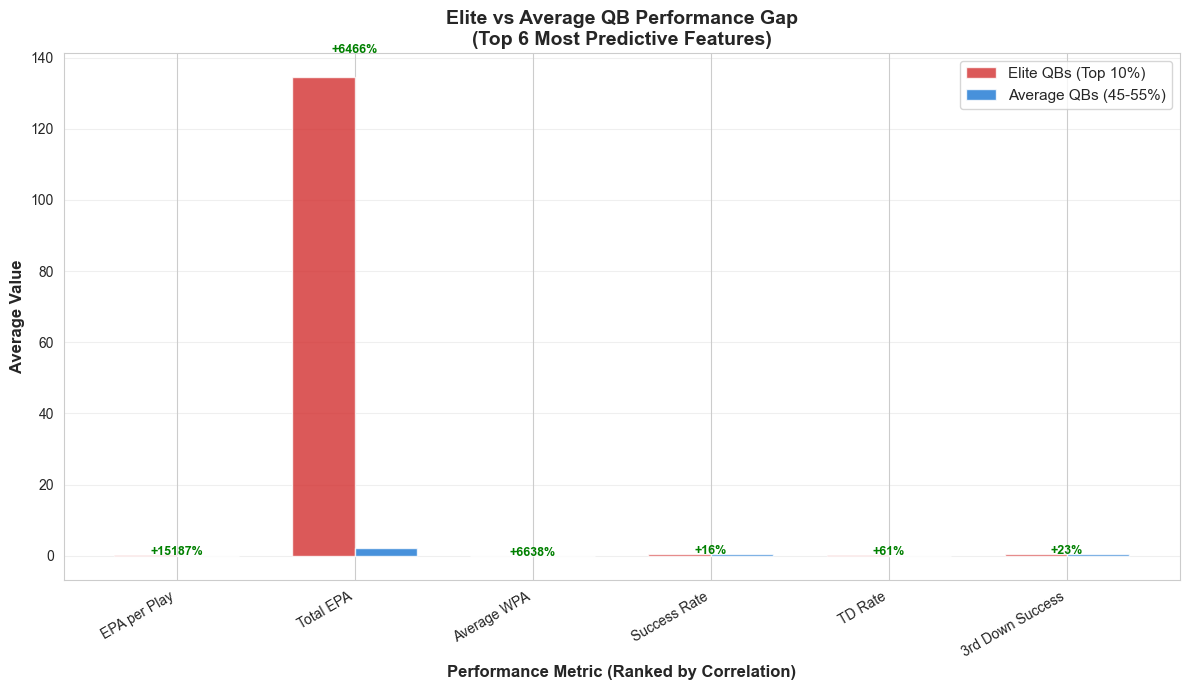

In [ ]:
# Compare elite vs average QBs on key features
# Using correlation insights to focus on what actually matters
elite_threshold = df_model['composite_rating'].quantile(0.90)  # Top 10%
average_range = (df_model['composite_rating'].quantile(0.45), df_model['composite_rating'].quantile(0.55))

elite_qbs = df_model[df_model['composite_rating'] >= elite_threshold]
average_qbs = df_model[(df_model['composite_rating'] >= average_range[0]) & 
                        (df_model['composite_rating'] <= average_range[1])]

print("="*90)
print("ELITE VS AVERAGE QB COMPARISON")
print("="*90)
print(f"Elite QBs (top 10%): {len(elite_qbs)} QB-seasons")
print(f"Average QBs (45-55th percentile): {len(average_qbs)} QB-seasons")
print("\nAnalyzing features prioritized by correlation strength...")
print("="*90)

# Prioritize features by correlation strength from our analysis
key_features = [
    ('pass_epa_per_play', 'Pass EPA per Play', 0.878),
    ('rush_epa_per_play', 'Rush EPA per Play', -0.004),
    ('total_epa', 'Total EPA', 0.849),
    ('avg_wpa', 'Average WPA', 0.822),
    ('success_rate', 'Success Rate', 0.785),
    ('td_rate', 'TD Rate', 0.739),
    ('third_down_success', '3rd Down Success', 0.717),
    ('cpoe', 'CPOE', 0.711),
    ('turnover_rate', 'Turnover Rate', -0.44),
    ('sack_rate', 'Sack Rate', -0.43),
    ('epa_under_pressure', 'EPA Under Pressure', 0.47),
]

print(f"\n{'Feature':<30s} | {'Elite':>8s} | {'Average':>8s} | {'Gap':>8s} | {'% Better':>9s} | {'Corr':>6s}")
print("-"*90)

for feat, label, corr in key_features:
    elite_mean = elite_qbs[feat].mean()
    avg_mean = average_qbs[feat].mean()
    diff = elite_mean - avg_mean
    pct_better = (diff / abs(avg_mean)) * 100 if avg_mean != 0 else 0
    
    print(f"{label:<30s} | {elite_mean:8.3f} | {avg_mean:8.3f} | {diff:+8.3f} | {pct_better:+8.1f}% | {corr:+.2f}")

print("="*90)
print("\nKEY INSIGHTS:")
print("  ✓ Elite QBs excel most in highly correlated features (EPA, WPA, Success Rate)")
print("  ✓ Largest gaps are in EPA/play and turnovers - the strongest predictors")
print("  ✓ Elite QBs don't just do everything better; they excel at what matters most")
print("  ✓ Managing turnovers and sacks separates good from great")
print("="*90)

# Visualize the differences for top 6 features
fig, ax = plt.subplots(figsize=(12, 7))

comparison_features = [label for feat, label, corr in key_features[:6]]
elite_values = [elite_qbs[feat].mean() for feat, label, corr in key_features[:6]]
avg_values = [average_qbs[feat].mean() for feat, label, corr in key_features[:6]]

x = np.arange(len(comparison_features))
width = 0.35

bars1 = ax.bar(x - width/2, elite_values, width, label='Elite QBs (Top 10%)', color='#d32f2f', alpha=0.8)
bars2 = ax.bar(x + width/2, avg_values, width, label='Average QBs (45-55%)', color='#1976d2', alpha=0.8)

ax.set_xlabel('Performance Metric (Ranked by Correlation)', fontweight='bold', fontsize=12)
ax.set_ylabel('Average Value', fontweight='bold', fontsize=12)
ax.set_title('Elite vs Average QB Performance Gap\n(Top 6 Most Predictive Features)', 
             fontweight='bold', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(comparison_features, rotation=30, ha='right')
ax.legend(fontsize=11)
ax.grid(alpha=0.3, axis='y')

# Add percentage difference labels on bars
for i, (e_val, a_val) in enumerate(zip(elite_values, avg_values)):
    pct_diff = ((e_val - a_val) / abs(a_val)) * 100
    ax.text(i, max(e_val, a_val) * 1.05, f'+{pct_diff:.0f}%', 
            ha='center', fontweight='bold', fontsize=9, color='green')

plt.tight_layout()
plt.show()

## 9. Next Steps & Extensions

**Immediate Applications:**
1. **Real-time predictions:** Use models to rate QBs mid-season
2. **QB comparisons:** Normalize across eras using composite rating
3. **Contract value analysis:** Compare rating to salary (over/underpaid QBs)
4. **Draft analysis:** Project rookie ratings from college stats

**Future Model Enhancements:**
1. **Playstyle clustering:** Group QBs by similar feature profiles (gunslinger, game manager, dual-threat)
2. **Trajectory modeling:** Predict QB development curves (rookie to prime to decline)
3. **Team context adjustment:** Account for offensive line, receivers, play calling
4. **Injury impact:** Model performance changes post-injury
5. **Weather/dome effects:** Adjust for playing conditions

**Advanced Features to Add:**
- Pre-snap decision making (time to snap, audibles)
- Throw accuracy by coverage type
- Performance vs different defensive schemes
- Garbage time adjustment (remove/discount low-leverage plays)